# Interactive notebook for the gpt_constructor package

## Imports

### Package imports

In [9]:
import os
import tiktoken
from statemachine import StateMachine 
from gpt_controller.config import CHATGPT_MODEL, PROMPT_PATH, SELF_TRAIN
from gpt_controller.chat_gpt_interface.api_tools import InHouseAPI
from gpt_controller.cognition.machine import GPTControllerMachine

### Data imports

In [10]:
# TODO Load the sqlalchemy models from database
chatGPT_api = InHouseAPI()
prompt_deck = chatGPT_api.get_prompt_deck()
environment_deck = chatGPT_api.get_environment_deck()

## Overview

### 1. State Machine Diagram

Entering 'idle' state from '__initial__' event.


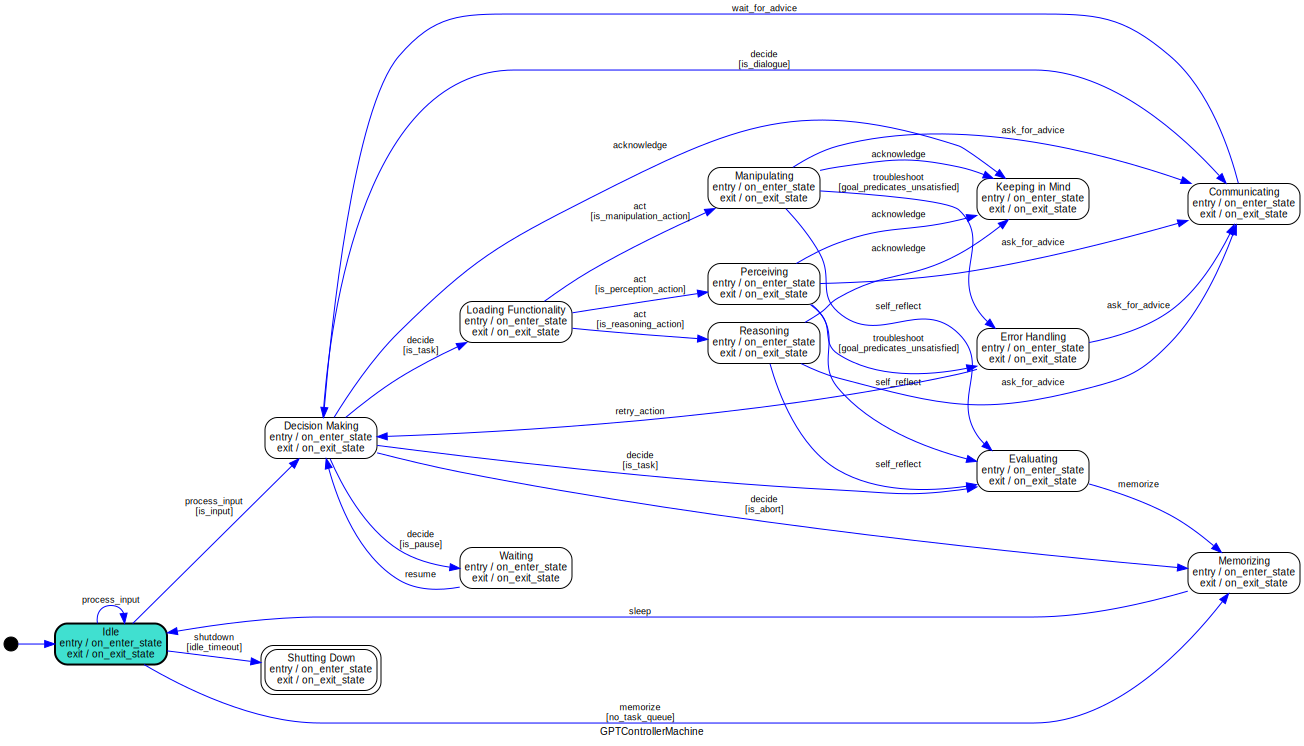

In [11]:
state_machine = GPTControllerMachine()
#TODO #12 Edit states maybe to make the graph more intuitive: https://graphviz.gitlab.io/pdf/dotguide.pdf
state_machine

#### 1.1 Notable state transitions

##### 1.1.1 `decision_making`

`decide` transition function:

```python
class Flag(Enum):
    TASK                        : 1 # New task to be completed (e.g. "Pick up the tomato.")
    QUESTION_ENV_KNOWLEDGE      : 2 # Question to be answered about the environment of the robot (e.g. "What is the color of the table?")
    QUESTION_GEN_KNOWLEDGE      : 3 # Question to be answered about general knowledge (e.g. "How heavy is a tomato on average?")
    ADVICE                      : 4 # Advice on how to complete a task (e.g. "You should pick up the tomato from above.")
    ABORT                       : 5 # Abort the current task (e.g. "Stop what you're doing.")
    PAUSE                       : 6 # Pause the current task but don't abort it (e.g. "Wait a moment.")
    UNCERTAIN                   : 7 # None of the above tags apply (e.g. "I think cats are cute.")
```

For decision_making.to(communicating, cond=["is_dialogue"]): 
- Condition is true if input is either `Flag.QUESTION_ENV_KNOWLEDGE`, `Flag.QUESTION_GEN_KNOWLEDGE`, `Flag.UNCERTAIN`.

### 2. Prompt benchmarks

In [12]:

for prompt_label, prompt in prompt_deck.items():
    num_tokens = chatGPT_api.num_tokens_prompt(prompt)
    print("Prompt: {} \nNumber of tokens: {}\n".format(prompt_label, num_tokens))


Prompt: general_capabilities.txt 
Number of tokens: 27

Prompt: grasp.txt 
Number of tokens: 901

Prompt: task_segmentation.txt 
Number of tokens: 772

Prompt: slot_fill_description_based_querry.txt 
Number of tokens: 48

Prompt: set_goal_predicates.txt 
Number of tokens: 325

Prompt: perception_classification.txt 
Number of tokens: 237

Prompt: task_segmentation_with_navigability.txt 
Number of tokens: 396

Prompt: user_input_labelling.txt 
Number of tokens: 273



In [13]:
for environment_label, environment in environment_deck.items():
    num_tokens = chatGPT_api.num_tokens_prompt(environment)
    print("Prompt: {} \nNumber of tokens: {}\n".format(environment_label, num_tokens))

Prompt: kitchen.txt 
Number of tokens: 0



## Prompt Testing

Load and test output of specific completion context with:
    
```python
chatGPT_api.request_completion()
```

In [14]:

print(prompt_deck.keys())
# TODO #2 Make this work
chatGPT_api.request_completion(
    prompt_name="user_input_labelling.txt", 
    user_request="You can find a tomato in the fridge"
)

dict_keys(['general_capabilities.txt', 'grasp.txt', 'task_segmentation.txt', 'slot_fill_description_based_querry.txt', 'set_goal_predicates.txt', 'perception_classification.txt', 'task_segmentation_with_navigability.txt', 'user_input_labelling.txt'])
QUESTION_ENV_KNOWLEDGE


'QUESTION_ENV_KNOWLEDGE'

## Self training [#7](https://github.com/andrei-calin-dragomir/gpt-robot-controller/issues/7)

Self training is a method of training a model on its own output. This is done by using the output of the model as the input to the model. This is done iteratively to improve the model's performance on a specific task.

### 1. Self-training text based

#### Setup
    
- Set `SELF_TRAIN` to `True` in `config.py` to enable self-training.
- Set `PERSISTENT_ENVIRONMENTS = True` in `config.py` to enable persistent environments.
- Set `TOKEN_LIMIT` to your desired tokens to use in one run of self training.

Self-training can potentially run indefinitely resulting in large token counts. To prevent this, set `TOKEN_LIMIT` to a value that you are comfortable with.

#### Environment Descriptions

This method allows you to create a root description of the environment you want the machine to train in.
To do so, add an environment description as a `.txt` file in the `prompts/environment` folder in the root directory of the package.

#### Usage
```python
GPTControllerMachine().self_train(environment="environment_name.txt")
```

#### Inner workings
This will generate a state machine with a Spawning state.
Whenever the model is in the Idle state:
    If `TOKEN_LIMIT` is reached, the model will go to the Finish state and then shut down.
    Otherwise, it will go to Spawning state and generate a new environment or new task to train on.

In [15]:
environment_deck.keys()

dict_keys(['kitchen.txt'])

In [16]:
GPTControllerMachine().self_train(environment="environment_name.txt")

Entering 'idle' state from '__initial__' event.


## Multi-tasking 
# TODO: #14 Add multi-tasking support

- In this state, the system will either:
    - Pop a user input entry from the input queue and label it.
        - If the system is in a critical state: 
            - If the task is a `Flag.ABORT`:
                - The system will not context switch to the new task.
                - The system will push the task back to the input queue.
            - If the task is a `Flag.PAUSE`:
        - If the system is in an interruptible state:
                - If the task is a `Flag.ABORT` or `Flag.PAUSE`:
                    - The system will push the new task to finalize.
                - The system will push the current task to the task queue.
Pop a task from the task queue and run it.
- or memorizes the input if it represents 
- or takes a task from the task queue.

```python
class Importance(Enum):
    LOOSE           : 1
    INTERRUPTIBLE   : 2 
    CRITICAL        : 3 
```

- If the task is loose, the robot can completely context switch to the new task.
- If the task is interruptible, the robot can be interrupted from the current task but only specific types of tasks will be handled.
- If the task is critical, the robot cannot be interrupted from the current task.